## Imports

In [121]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import torch.nn as nn
import copy

### Setting random seeds

In [123]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### Importing the data and forming the graphs

In [612]:
mdna = pd.read_csv('dna_feature_selected.csv')
mge = pd.read_csv('mrna_feature_selected.csv')
mcna = pd.read_csv('cna_feature_selected.csv')

In [614]:
# Merge the dataframes on 'SAMPLE_ID' just to get the labels
merged_df = mdna.merge(mge, on='SAMPLE_ID').merge(mcna, on='SAMPLE_ID')

In [616]:
# Separate features and labels
X_mdna = mdna.drop(columns=['SAMPLE_ID', 'CLASS'])
X_mge = mge.drop(columns=['SAMPLE_ID', 'CLASS'])
X_mcna = mcna.drop(columns=['SAMPLE_ID', 'CLASS'])
y = merged_df['CLASS']

In [618]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

In [620]:
# Convert numpy arrays to torch tensors
X_mdna_tensor = torch.tensor(X_mdna.values, dtype=torch.float32) # Convert DataFrame to NumPy array using .values
X_mge_tensor = torch.tensor(X_mge.values, dtype=torch.float32)   # Convert DataFrame to NumPy array using .values
X_mcna_tensor = torch.tensor(X_mcna.values, dtype=torch.float32)  # Convert DataFrame to NumPy array using .values

### Using DMCCA for dimensionality reduction

In [622]:
class DMCCA(nn.Module):
    def __init__(self, input_dims, latent_dim, dropout=0.2):
        super(DMCCA, self).__init__()
        self.latent_dim = latent_dim
        self.encoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_dim, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, latent_dim)
            )
            for in_dim in input_dims
        ])
        self.decoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, 128),
                nn.ReLU(),
                nn.Linear(128, in_dim)
            )
            for in_dim in input_dims
        ])

    def forward(self, views):
        z_list = [encoder(view) for encoder, view in zip(self.encoders, views)]
        return z_list

    def get_joint_embedding(self, z_list):
        return torch.mean(torch.stack(z_list), dim=0)

    def reconstruct(self, z_joint):
        recons = [decoder(z_joint) for decoder in self.decoders]
        return recons

In [624]:
# Instantiate DMCCA
input_dims = [X_mdna.shape[1], X_mge.shape[1], X_mcna.shape[1]]
latent_dim = 64  # You can tune this
dmcca = DMCCA(input_dims=input_dims, latent_dim=latent_dim)

# Optimizer
optimizer = torch.optim.Adam(dmcca.parameters(), lr=0.001)

# Train DMCCA (simple unsupervised loss: minimize pairwise distance between views)
num_epochs = 100
for epoch in range(num_epochs):
    dmcca.train()
    optimizer.zero_grad()

    zs = dmcca([X_mdna_tensor, X_mge_tensor, X_mcna_tensor])
    loss = sum(F.mse_loss(z1, z2) for i, z1 in enumerate(zs) for j, z2 in enumerate(zs) if i < j)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.1157
Epoch 10, Loss: 0.0230
Epoch 20, Loss: 0.0152
Epoch 30, Loss: 0.0100
Epoch 40, Loss: 0.0076
Epoch 50, Loss: 0.0060
Epoch 60, Loss: 0.0049
Epoch 70, Loss: 0.0040
Epoch 80, Loss: 0.0033
Epoch 90, Loss: 0.0028


### Constructing the shared latent space and upsampling using SMOTE

In [626]:
dmcca.eval()
with torch.no_grad():
    zs = dmcca([X_mdna_tensor, X_mge_tensor, X_mcna_tensor])
X_dmcca = torch.stack(zs).mean(dim=0).numpy()  # Latent space

# Step 2: Apply SMOTE in latent space
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_dmcca, y)

In [628]:
from sklearn.neighbors import kneighbors_graph

adj = kneighbors_graph(X_smote, n_neighbors=10, mode='distance', include_self=False)
similarities = 1 / (adj.data + 1e-8)
adj.data = similarities

edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)

### Train-test split (70-30)

In [630]:
x_target = torch.tensor(X_smote, dtype=torch.float32)
y_tensor = torch.tensor(y_smote, dtype=torch.long)

In [632]:
# Train/test split
train_idx, test_idx = train_test_split(np.arange(len(y_smote)), test_size=0.3, stratify=y_smote, random_state=42)
train_mask = torch.zeros(len(y_smote), dtype=torch.bool)
test_mask = torch.zeros(len(y_smote), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

In [634]:
# PyTorch Geometric format
x = torch.tensor(X_smote, dtype=torch.float32)
y_tensor = torch.tensor(y_smote, dtype=torch.long)
# Build data object
data = Data(x=x, edge_index=edge_index, y=y_tensor)
data.train_mask = train_mask
data.test_mask = test_mask

In [636]:
# === Define GAT ===
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=2, concat=True)               # output: hidden_dim * 2
        self.conv_mid = GATConv(hidden_dim * 2, hidden_dim, heads=2, concat=True)       # output: hidden_dim * 2
        self.conv2 = GATConv(hidden_dim * 2, output_dim, heads=1, concat=False)         # output: output_dim

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv_mid(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv2(x, edge_index)
        return x


## Model Before SMOTE

In [679]:
from torch.optim.lr_scheduler import StepLR
#=== Step 1: Split before SMOTE
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_dmcca, y, test_size=0.3, stratify=y, random_state=42
)

# === Step 2: Combine for full dataset
X_all_raw = np.vstack([X_train_raw, X_test_raw])
y_all_raw = np.concatenate([y_train_raw, y_test_raw])

# === Step 3: Recompute edge_index for raw (pre-SMOTE) data
adj_raw = kneighbors_graph(X_all_raw, n_neighbors=10, mode='distance', include_self=False)
similarities_raw = 1 / (adj_raw.data + 1e-8)
adj_raw.data = similarities_raw
edge_index_raw = torch.tensor(np.vstack(adj_raw.nonzero()), dtype=torch.long)

# === Step 4: Create Data object with raw data
x_raw = torch.tensor(X_all_raw, dtype=torch.float32)
y_tensor_raw = torch.tensor(y_all_raw, dtype=torch.long)
train_mask_raw = torch.zeros(len(y_all_raw), dtype=torch.bool)
test_mask_raw = torch.zeros(len(y_all_raw), dtype=torch.bool)
train_mask_raw[:len(X_train_raw)] = True
test_mask_raw[len(X_train_raw):] = True

data_raw = Data(x=x_raw, edge_index=edge_index_raw, y=y_tensor_raw)
data_raw.train_mask = train_mask_raw
data_raw.test_mask = test_mask_raw

# === Train GAT ===
model = GAT(input_dim=x_raw.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0.0
patience = 10
counter = 0
best_model_state = None

num_epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    scheduler.step()
    optimizer.zero_grad()
    out = model(data_raw)
    loss = criterion(out[data_raw.train_mask], data_raw.y[data_raw.train_mask])
    loss.backward()
    optimizer.step()

    # === Evaluate on test mask
    model.eval()
    with torch.no_grad():
        logits = model(data_raw)
        probs = F.softmax(logits[data_raw.test_mask], dim=1)[:, 1].cpu().numpy()
        true = data_raw.y[data_raw.test_mask].cpu().numpy()
        auc = roc_auc_score(true, probs)

    preds = out[data_raw.train_mask].argmax(dim=1)
    labels = data_raw.y[data_raw.train_mask]
    acc = (preds == labels).float().mean().item()

    train_losses.append(loss.item())
    train_accuracies.append(acc)
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test AUC: {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} — Best Test AUC: {best_auc:.4f}")
            break

# Load best model
model.load_state_dict(best_model_state)

C:\Users\arvin\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0, Loss: 0.7048, Test AUC: 0.5747
Epoch 1, Loss: 0.6916, Test AUC: 0.5542
Epoch 2, Loss: 0.6768, Test AUC: 0.5408
Epoch 3, Loss: 0.6693, Test AUC: 0.5323
Epoch 4, Loss: 0.6571, Test AUC: 0.5292
Epoch 5, Loss: 0.6459, Test AUC: 0.5212
Epoch 6, Loss: 0.6403, Test AUC: 0.5177
Epoch 7, Loss: 0.6294, Test AUC: 0.5153
Epoch 8, Loss: 0.6248, Test AUC: 0.5160
Epoch 9, Loss: 0.6152, Test AUC: 0.5132
Epoch 10, Loss: 0.6085, Test AUC: 0.5135
Early stopping at epoch 10 — Best Test AUC: 0.5747


<All keys matched successfully>

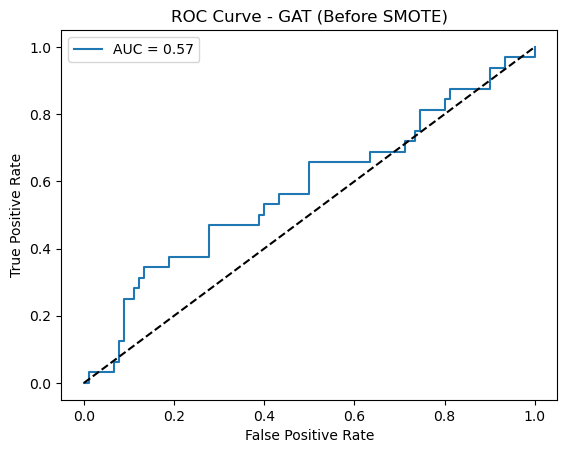

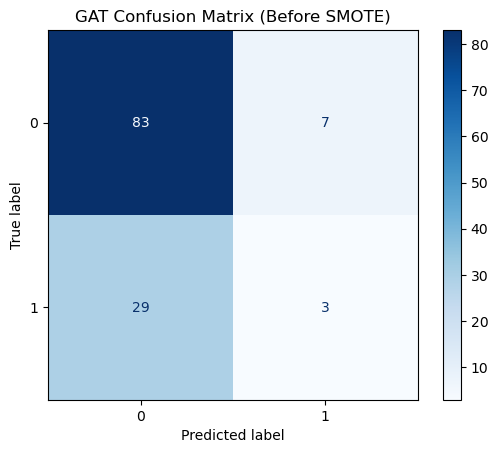

Accuracy       : 0.7049
Precision      : 0.3000
Recall         : 0.0938
F1 Score       : 0.1429
AUC (ROC)      : 0.5747


In [681]:
# === Evaluate GAT on raw data ===
model.eval()
with torch.no_grad():
    logits_raw = model(data_raw)
    preds_raw = logits_raw.argmax(dim=1)
    probs_raw = F.softmax(logits_raw, dim=1)[:, 1]  # Probabilities for class 1

# Convert to numpy
probs_np_raw = probs_raw[data_raw.test_mask].cpu().numpy()
true_labels_raw = data_raw.y[data_raw.test_mask].cpu().numpy()
pred_labels_raw = preds_raw[data_raw.test_mask].cpu().numpy()

# === ROC Curve & AUC
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
fpr_raw, tpr_raw, _ = roc_curve(true_labels_raw, probs_np_raw)
roc_auc_raw = auc(fpr_raw, tpr_raw)

plt.figure()
plt.plot(fpr_raw, tpr_raw, label=f"AUC = {roc_auc_raw:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GAT (Before SMOTE)")
plt.legend()
plt.savefig("gat_roc_raw.png", dpi=300)
plt.show()

# === Confusion Matrix
cm_raw = confusion_matrix(true_labels_raw, pred_labels_raw)
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw)
disp_raw.plot(cmap="Blues", values_format='d')
plt.title("GAT Confusion Matrix (Before SMOTE)")
plt.savefig("gat_confmat_raw.png", dpi=300)
plt.show()

# === Classification Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_raw = accuracy_score(true_labels_raw, pred_labels_raw)
precision_raw = precision_score(true_labels_raw, pred_labels_raw)
recall_raw = recall_score(true_labels_raw, pred_labels_raw)
f1_raw = f1_score(true_labels_raw, pred_labels_raw)

print(f"Accuracy       : {accuracy_raw:.4f}")
print(f"Precision      : {precision_raw:.4f}")
print(f"Recall         : {recall_raw:.4f}")
print(f"F1 Score       : {f1_raw:.4f}")
print(f"AUC (ROC)      : {roc_auc_raw:.4f}")


In [638]:
# === Train GAT ===
model = GAT(input_dim=x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

In [640]:
criterion = torch.nn.CrossEntropyLoss()

# === Early stopping settings
best_auc = 0.0
patience = 10
counter = 0
best_model_state = None

num_epochs = 100
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    # === Evaluate on test mask
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits[data.test_mask], dim=1)[:, 1].cpu().numpy()
        true = data.y[data.test_mask].cpu().numpy()
        auc = roc_auc_score(true, probs)
    preds = out[data.train_mask].argmax(dim=1)
    labels = data.y[data.train_mask]
    acc = (preds == labels).float().mean().item()

    train_losses.append(loss.item())
    train_accuracies.append(acc)
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test AUC: {auc:.4f}")

    # === Early stopping check
    if auc > best_auc:
        best_auc = auc
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} — Best Test AUC: {best_auc:.4f}")
            break

# === Load the best model
model.load_state_dict(best_model_state)

Epoch 0, Loss: 0.6938, Test AUC: 0.6087
Epoch 1, Loss: 0.6915, Test AUC: 0.6248
Epoch 2, Loss: 0.6911, Test AUC: 0.6413
Epoch 3, Loss: 0.6912, Test AUC: 0.6521
Epoch 4, Loss: 0.6913, Test AUC: 0.6596
Epoch 5, Loss: 0.6903, Test AUC: 0.6652
Epoch 6, Loss: 0.6914, Test AUC: 0.6698
Epoch 7, Loss: 0.6916, Test AUC: 0.6763
Epoch 8, Loss: 0.6892, Test AUC: 0.6801
Epoch 9, Loss: 0.6896, Test AUC: 0.6848
Epoch 10, Loss: 0.6882, Test AUC: 0.6864
Epoch 11, Loss: 0.6889, Test AUC: 0.6871
Epoch 12, Loss: 0.6898, Test AUC: 0.6888
Epoch 13, Loss: 0.6877, Test AUC: 0.6925
Epoch 14, Loss: 0.6877, Test AUC: 0.6970
Epoch 15, Loss: 0.6857, Test AUC: 0.6984
Epoch 16, Loss: 0.6873, Test AUC: 0.6995
Epoch 17, Loss: 0.6873, Test AUC: 0.7012
Epoch 18, Loss: 0.6872, Test AUC: 0.7016
Epoch 19, Loss: 0.6859, Test AUC: 0.7039
Epoch 20, Loss: 0.6843, Test AUC: 0.7047
Epoch 21, Loss: 0.6851, Test AUC: 0.7045
Epoch 22, Loss: 0.6848, Test AUC: 0.7045
Epoch 23, Loss: 0.6848, Test AUC: 0.7047
Epoch 24, Loss: 0.6849, Te

<All keys matched successfully>

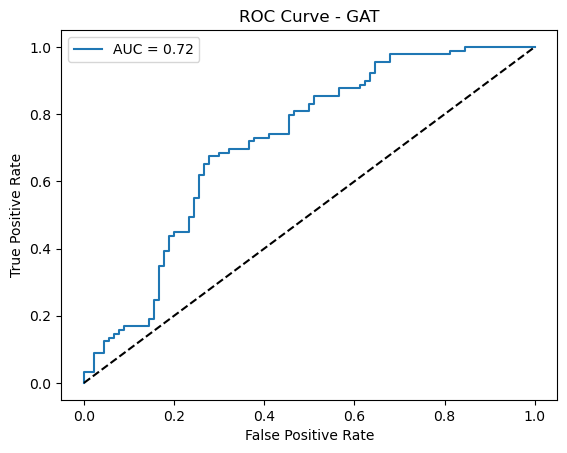

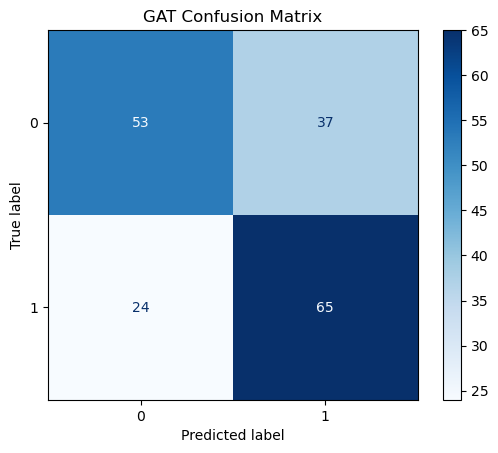

Accuracy       : 0.6592
Precision      : 0.6373
Recall         : 0.7303
F1 Score       : 0.6806
AUC (ROC)      : 0.7157


In [642]:
# === Evaluate GAT ===
model.eval()
with torch.no_grad():
    logits = model(data)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)[:, 1]  # Probabilities for class 1

# Convert to numpy
probs_np = probs[data.test_mask].cpu().numpy()
true_labels = data.y[data.test_mask].cpu().numpy()
pred_labels = preds[data.test_mask].cpu().numpy()

# === ROC Curve & AUC
fpr, tpr, _ = roc_curve(true_labels, probs_np)
# Use sklearn.metrics.auc instead of the overwritten variable
from sklearn.metrics import auc  # Make sure auc is imported
roc_auc_smote = auc(fpr, tpr) # Changed the variable name to 'roc_auc_score'

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_smote:.2f}") # Use the new variable name here
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GAT")
plt.legend()
plt.savefig("blca-roc.png",dpi=300)
plt.show()

# === Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("GAT Confusion Matrix")
plt.savefig("blca-confmat.png",dpi=300)
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"AUC (ROC)      : {roc_auc_smote:.4f}")

<Figure size 1200x500 with 0 Axes>

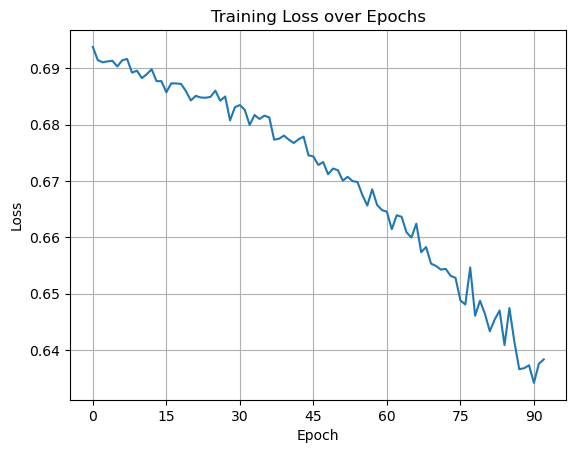

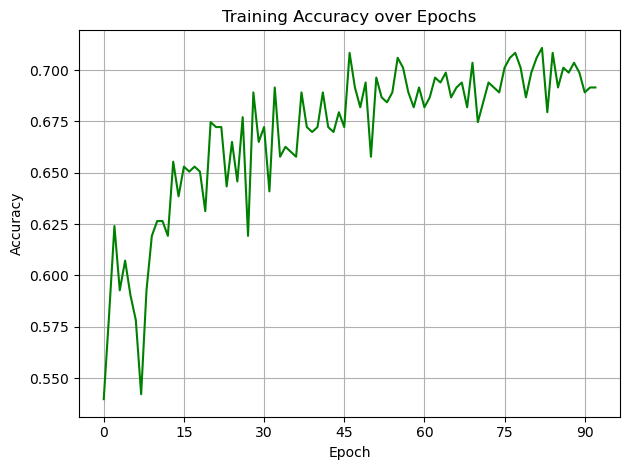

In [644]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(12, 5))

plt.figure()
plt.plot(train_losses, label='Loss')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.savefig("blca-loss.png",dpi=300)
plt.show()

plt.figure()
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.tight_layout()
plt.savefig("blca-accuracy.png",dpi=300)
plt.show()

C:\Users\arvin\AppData\Local\Temp\ipykernel_46264\892316092.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gat_model_blca.pt"))


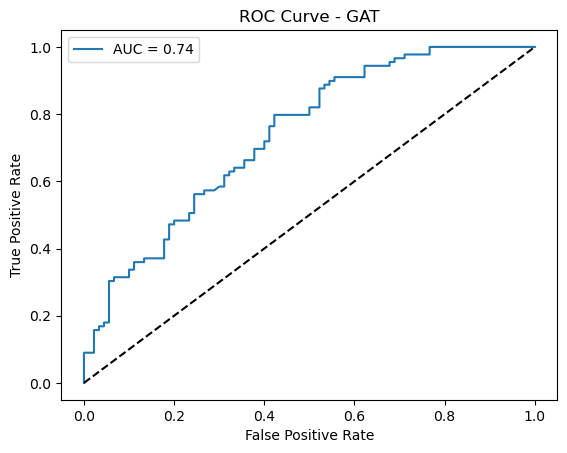

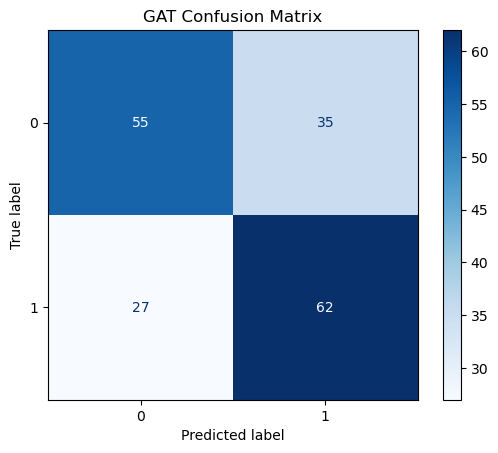

Accuracy       : 0.6536
Precision      : 0.6392
Recall         : 0.6966
F1 Score       : 0.6667
AUC (ROC)      : 0.7370


In [504]:
best_model_state = model.state_dict()
torch.save(best_model_state, "best_gat_model_blca.pt")

model = GAT(input_dim=x.shape[1])
model.load_state_dict(torch.load("best_gat_model_blca.pt"))
model.eval()

with torch.no_grad():
    logits = model(data)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)[:, 1]  # Probabilities for class 1

# Convert to numpy
probs_np = probs[data.test_mask].cpu().numpy()
true_labels = data.y[data.test_mask].cpu().numpy()
pred_labels = preds[data.test_mask].cpu().numpy()

# === ROC Curve & AUC
fpr, tpr, _ = roc_curve(true_labels, probs_np)
# Use sklearn.metrics.auc instead of the overwritten variable
from sklearn.metrics import auc  # Make sure auc is imported
roc_auc_smote = auc(fpr, tpr) # Changed the variable name to 'roc_auc_score'

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_smote:.2f}") # Use the new variable name here
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GAT")
plt.legend()
plt.show()

# === Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("GAT Confusion Matrix")
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"AUC (ROC)      : {roc_auc_smote:.4f}")

## Evaluating the shared latent space

In [646]:
model.eval()
with torch.no_grad():
    x = model.conv1(data.x, data.edge_index)
    x = F.elu(x)
    x = F.dropout(x, p=0.4, training=False)
    
    latent = model.conv_mid(x, data.edge_index)  # Shape: [510, features]
    latent = F.elu(latent)
    shared_latent_np = latent.cpu().numpy()  # Shape: [510, ?]

labels = data.y.cpu().numpy()

In [648]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness

# Silhouette Score (for cluster separation)
sil_score = silhouette_score(shared_latent_np, labels)
print(f"Silhouette Score (Full Data): {sil_score:.4f}")

# Trustworthiness (for local neighborhood preservation)
trust = trustworthiness(X_smote, shared_latent_np, n_neighbors=10)
print(f"Trustworthiness: {trust:.4f}")

Silhouette Score (Full Data): 0.1199
Trustworthiness: 0.9141


In [650]:
mask = data.test_mask.cpu().numpy()  # or train_mask, depending on what you're using
Z_subset = shared_latent_np[mask]
labels_subset = labels[mask]

from sklearn.manifold import trustworthiness
trust = trustworthiness(X_smote, shared_latent_np, n_neighbors=10)
print(f"Trustworthiness: {trust:.4f}")

Trustworthiness: 0.9141


## Visualizing the shared latent space after dimensionality reduction using UMAP

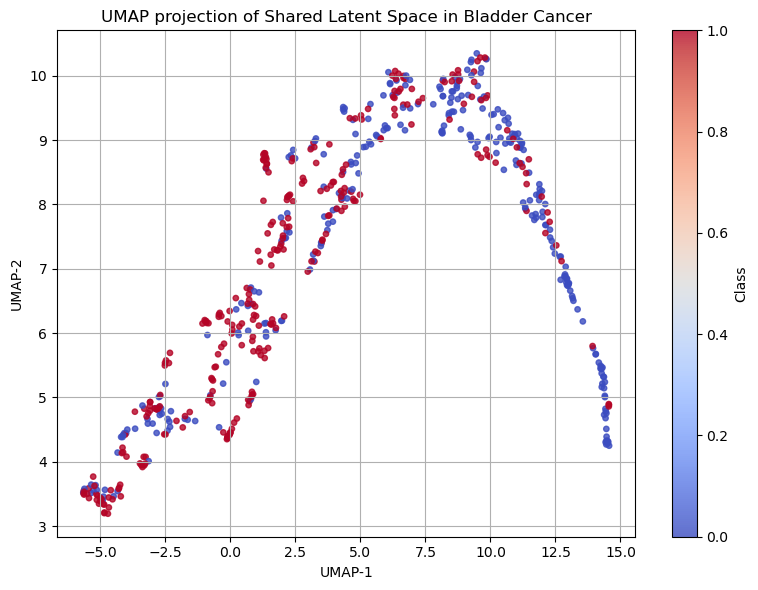

In [660]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

umap_proj = umap.UMAP(n_neighbors=15).fit_transform(shared_latent_np)

plt.figure(figsize=(8,6))
plt.scatter(umap_proj[:,0], umap_proj[:,1], c=labels, cmap='coolwarm', s=15, alpha=0.8)
plt.title("UMAP projection of Shared Latent Space in Bladder Cancer")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Class')
plt.grid(True)
plt.tight_layout()
plt.savefig("umap_blca.png", dpi=300)
plt.show()

In [654]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

clf = LogisticRegression()
clf.fit(shared_latent_np[train_mask], labels[train_mask])
probs = clf.predict_proba(shared_latent_np[test_mask])[:, 1]
preds = clf.predict(shared_latent_np[test_mask])

print("AUC:", roc_auc_score(labels[test_mask], probs))
print("Accuracy:", accuracy_score(labels[test_mask], preds))

AUC: 0.7245942571785269
Accuracy: 0.7039106145251397


In [656]:
dmcca.eval()
with torch.no_grad():
    zs = dmcca([X_mdna_tensor, X_mge_tensor, X_mcna_tensor])  # List of [z_mdna, z_mge, z_mcna]
    z_joint = dmcca.get_joint_embedding(zs)  # Combine into shared latent space (shape: [batch, latent_dim])
    recons = dmcca.reconstruct(z_joint)     # Decode the joint embedding

import torch.nn.functional as F

loss_mdna = F.mse_loss(recons[0], X_mdna_tensor)
loss_mge  = F.mse_loss(recons[1], X_mge_tensor)
loss_mcna = F.mse_loss(recons[2], X_mcna_tensor)
avg_loss  = (loss_mdna + loss_mge + loss_mcna) / 3

print(f"Reconstruction Loss (mDNA): {loss_mdna.item():.4f}")
print(f"Reconstruction Loss (GE):   {loss_mge.item():.4f}")
print(f"Reconstruction Loss (CNA):  {loss_mcna.item():.4f}")
print(f"Average Reconstruction Loss: {avg_loss.item():.4f}")

Reconstruction Loss (mDNA): 0.2300
Reconstruction Loss (GE):   0.0496
Reconstruction Loss (CNA):  0.3073
Average Reconstruction Loss: 0.1957


### k-fold cross validation

In [199]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store fold results
cv_auc = []
cv_acc = []
cv_f1 = []


=== Fold 1 ===
AUC: 0.8201, Accuracy: 0.7815, F1: 0.7869

=== Fold 2 ===
AUC: 0.7189, Accuracy: 0.6387, F1: 0.6325

=== Fold 3 ===
AUC: 0.7610, Accuracy: 0.6387, F1: 0.5743

=== Fold 4 ===
AUC: 0.7811, Accuracy: 0.6555, F1: 0.7285

=== Fold 5 ===
AUC: 0.7506, Accuracy: 0.7034, F1: 0.7482


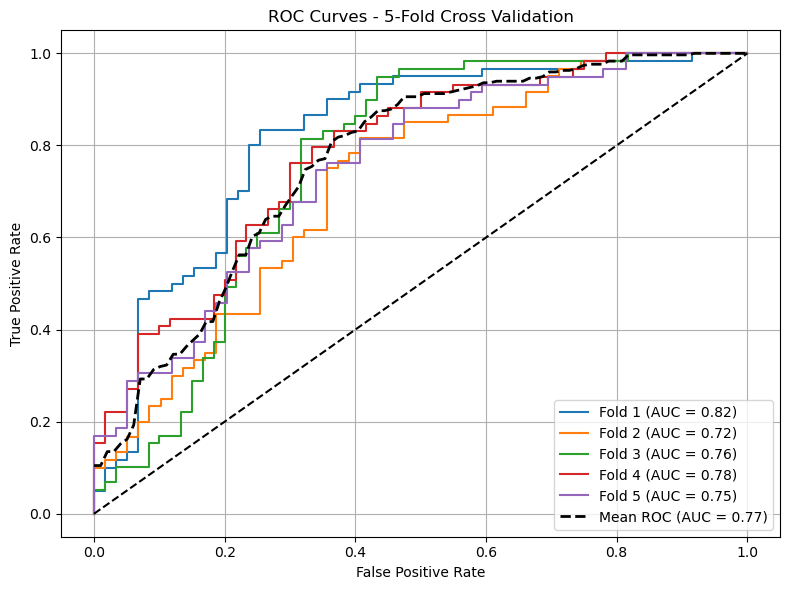


=== 5-Fold CV Summary ===
Average AUC      : 0.7663
Average Accuracy : 0.6835
Average F1 Score : 0.6941


In [534]:
X = np.array(X_smote)
y = np.array(y_smote)

# === Build the graph ONCE
adj = kneighbors_graph(X, n_neighbors=10, mode='distance', include_self=False)
adj.data = 1 / (adj.data + 1e-8)
edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)

# === Initialize Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Storage for metrics
cv_auc, cv_acc, cv_f1 = [], [], []
fprs, tprs, roc_aucs = [], [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    # Create masks
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    # Create Data object
    data = Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long),
        train_mask=train_mask,
        test_mask=test_mask
    )

    # Define and train model
    model = GAT(input_dim=X.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(60):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # === Evaluate
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)

    # Extract test predictions
    probs_np = probs[test_mask].cpu().numpy()
    true_labels = data.y[test_mask].cpu().numpy()
    pred_labels = preds[test_mask].cpu().numpy()

    # Metrics
    auc_score = roc_auc_score(true_labels, probs_np)
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"AUC: {auc_score:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")

    cv_auc.append(auc_score)
    cv_acc.append(acc)
    cv_f1.append(f1)

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probs_np)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

# === Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1} (AUC = {roc_aucs[i]:.2f})')

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(5)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', linewidth=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - 5-Fold Cross Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Summary
print("\n=== 5-Fold CV Summary ===")
print(f"Average AUC      : {np.mean(cv_auc):.4f}")
print(f"Average Accuracy : {np.mean(cv_acc):.4f}")
print(f"Average F1 Score : {np.mean(cv_f1):.4f}")


=== Fold 1 ===
AUC: 0.7022, Accuracy: 0.6500, F1: 0.6441

=== Fold 2 ===
AUC: 0.8133, Accuracy: 0.7500, F1: 0.7692

=== Fold 3 ===
AUC: 0.8467, Accuracy: 0.6667, F1: 0.6000

=== Fold 4 ===
AUC: 0.8056, Accuracy: 0.7000, F1: 0.7568

=== Fold 5 ===
AUC: 0.8828, Accuracy: 0.7627, F1: 0.7941

=== Fold 6 ===
AUC: 0.8425, Accuracy: 0.7797, F1: 0.7797

=== Fold 7 ===
AUC: 0.7839, Accuracy: 0.6949, F1: 0.7188

=== Fold 8 ===
AUC: 0.7034, Accuracy: 0.6441, F1: 0.6557

=== Fold 9 ===
AUC: 0.7931, Accuracy: 0.7458, F1: 0.7619

=== Fold 10 ===
AUC: 0.7126, Accuracy: 0.7119, F1: 0.7213


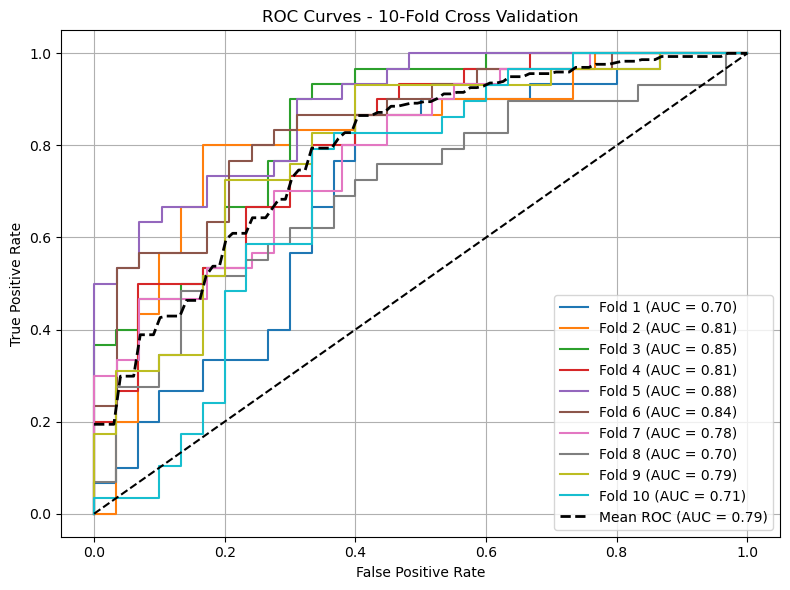


=== 10-Fold CV Summary ===
Average AUC      : 0.7886
Average Accuracy : 0.7106
Average F1 Score : 0.7202


In [64]:
# === Build the graph ONCE
adj = kneighbors_graph(X, n_neighbors=10, mode='distance', include_self=False)
adj.data = 1 / (adj.data + 1e-8)
edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)

# === Use 10-Fold Stratified CV
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Storage for metrics
cv_auc, cv_acc, cv_f1 = [], [], []
fprs, tprs, roc_aucs = [], [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    data = Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long),
        train_mask=train_mask,
        test_mask=test_mask
    )

    model = GAT(input_dim=X.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(60):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)

    probs_np = probs[test_mask].cpu().numpy()
    true_labels = data.y[test_mask].cpu().numpy()
    pred_labels = preds[test_mask].cpu().numpy()

    auc_score = roc_auc_score(true_labels, probs_np)
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"AUC: {auc_score:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")

    cv_auc.append(auc_score)
    cv_acc.append(acc)
    cv_f1.append(f1)

    fpr, tpr, _ = roc_curve(true_labels, probs_np)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

# === Plot Combined ROC Curves
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1} (AUC = {roc_aucs[i]:.2f})')

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(10)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', linewidth=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - 10-Fold Cross Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final Summary
print("\n=== 10-Fold CV Summary ===")
print(f"Average AUC      : {np.mean(cv_auc):.4f}")
print(f"Average Accuracy : {np.mean(cv_acc):.4f}")
print(f"Average F1 Score : {np.mean(cv_f1):.4f}")

### Combined 5 or 10 fold cross validation


=== Fold 1 ===
Fold 1 AUC: 0.8156

=== Fold 2 ===
Fold 2 AUC: 0.8189

=== Fold 3 ===
Fold 3 AUC: 0.7378

=== Fold 4 ===
Fold 4 AUC: 0.7011

=== Fold 5 ===
Fold 5 AUC: 0.8080

=== Fold 6 ===
Fold 6 AUC: 0.7080

=== Fold 7 ===
Fold 7 AUC: 0.8483

=== Fold 8 ===
Fold 8 AUC: 0.6103

=== Fold 9 ===
Fold 9 AUC: 0.7000

=== Fold 10 ===
Fold 10 AUC: 0.8391


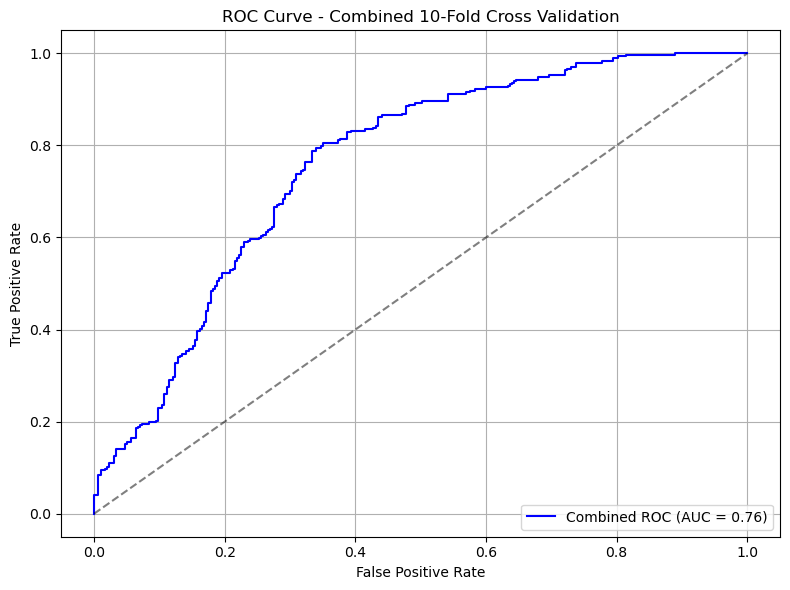

In [538]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score, accuracy_score, f1_score
)
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data

# === Build the Graph ONCE (kNN)
adj = kneighbors_graph(X, n_neighbors=10, mode='distance', include_self=False)
adj.data = 1 / (adj.data + 1e-8)  # Inverse distance as similarity
edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)

all_probs = []
all_true_labels = []

# === Stratified 10-Fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Metric Storage
cv_auc, cv_acc, cv_f1 = [], [], []
fprs, tprs, roc_aucs = [], [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    # Masks
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    # PyG Data object
    data = Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long),
        train_mask=train_mask,
        test_mask=test_mask
    )

    # GAT Model
    model = GAT(input_dim=X.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    # === Training
    for epoch in range(60):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # === Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)

    # === Collect predictions and true labels for this fold
    all_probs.extend(probs[test_mask].cpu().numpy())
    all_true_labels.extend(data.y[test_mask].cpu().numpy())

    # Optionally still compute per-fold AUC for logging
    auc_score = roc_auc_score(data.y[test_mask].cpu().numpy(), probs[test_mask].cpu().numpy())
    print(f"Fold {fold+1} AUC: {auc_score:.4f}")

    cv_auc.append(auc_score)
    cv_acc.append(acc)
    cv_f1.append(f1)

    fpr, tpr, _ = roc_curve(true_labels, probs_np)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

## === Final ROC Curve (Combined from all folds)
fpr, tpr, _ = roc_curve(all_true_labels, all_probs)
combined_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Combined ROC (AUC = {combined_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined 10-Fold Cross Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("blca_combined_10fold_roc.png", dpi=300)
plt.show()


### Training GAT before SMOTE

In [231]:
X_train = data.x[data.train_mask].cpu().numpy()
X_test = data.x[data.test_mask].cpu().numpy()
y_train = data.y[data.train_mask].cpu().numpy()
y_test = data.y[data.test_mask].cpu().numpy()

In [233]:
X_raw = X_dmcca
y_raw = y

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.3, stratify=y_raw, random_state=42
)

In [235]:
y_train_raw = np.where(y_train_raw == 2, 1, y_train_raw)
y_test_raw = np.where(y_test_raw == 2, 1, y_test_raw)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_raw = le.fit_transform(y_train_raw)
y_test_raw = le.transform(y_test_raw)

In [514]:
print("X_dmcca:", X_dmcca.shape)
print("y:", len(y))
print("X_smote:", X_smote.shape)
print("y_smote:", len(y_smote))
print(len(X), len(y))

X_dmcca: (404, 64)
y: 404
X_smote: (594, 64)
y_smote: 594
594 404


In [285]:
print("Unique values in y_train_raw:", np.unique(y_train_raw))

Unique values in y_train_raw: [0 1]


### ANN

In [273]:
import torch.nn as nn
import torch.optim as optim

class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.layers(x)

model_ann = ANN(input_dim=X_train_raw.shape[1])
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train_raw, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_raw, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_raw, dtype=torch.float32)

# Train
for epoch in range(50):
    model_ann.train()
    optimizer.zero_grad()
    out = model_ann(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict
model_ann.eval()
with torch.no_grad():
    logits = model_ann(X_test_tensor)
    probs_ann = F.softmax(logits, dim=1)[:, 1].numpy()
    preds_ann = logits.argmax(dim=1).numpy()

ann_auc = roc_auc_score(y_test_raw, probs_ann)
print(f"[ANN Before SMOTE] AUC: {ann_auc:.4f}, Accuracy: {accuracy_score(y_test_raw, preds_ann):.4f}")


[ANN Before SMOTE] AUC: 0.5590, Accuracy: 0.7377


In [283]:
model_ann = ANN(input_dim=X_train.shape[1])
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Train
for epoch in range(50):
    model_ann.train()
    optimizer.zero_grad()
    out = model_ann(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict
model_ann.eval()
with torch.no_grad():
    logits = model_ann(X_test_tensor)
    probs_ann = F.softmax(logits, dim=1)[:, 1].numpy()
    preds_ann = logits.argmax(dim=1).numpy()

ann_auc = roc_auc_score(y_test, probs_ann)
print(f"[ANN After SMOTE] AUC: {ann_auc:.4f}, Accuracy: {accuracy_score(y_test, preds_ann):.4f}")


[ANN After SMOTE] AUC: 0.7253, Accuracy: 0.6780


### Logistic Regression

In [296]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve
)

lr_raw = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_raw.fit(X_train_raw, y_train_raw)

probs_raw = lr_raw.predict_proba(X_test_raw)[:, 1]
preds_raw = lr_raw.predict(X_test_raw)

print("\n Before SMOTE:")
print(f"[Logistic Regression] AUC       : {roc_auc_score(y_test_raw, probs_raw):.4f}")
print(f"[Logistic Regression] Accuracy  : {accuracy_score(y_test_raw, preds_raw):.4f}")
print(f"[Logistic Regression] F1 Score  : {f1_score(y_test_raw, preds_raw):.4f}")


 Before SMOTE:
[Logistic Regression] AUC       : 0.7941
[Logistic Regression] Accuracy  : 0.6639
[Logistic Regression] F1 Score  : 0.5176


In [290]:
# Initialize logistic regression with balanced class weights
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predict probabilities and labels
lr_probs = lr.predict_proba(X_test)[:, 1]
lr_preds = lr.predict(X_test)

# Compute metrics
lr_auc = roc_auc_score(y_test, lr_probs)
lr_acc = accuracy_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)
lr_precision = precision_score(y_test, lr_preds)
lr_recall = recall_score(y_test, lr_preds)

# Print results
print("\n After SMOTE:")
print(f"[Logistic Regression] AUC       : {lr_auc:.4f}")
print(f"[Logistic Regression] Accuracy  : {lr_acc:.4f}")
print(f"[Logistic Regression] Precision : {lr_precision:.4f}")
print(f"[Logistic Regression] Recall    : {lr_recall:.4f}")
print(f"[Logistic Regression] F1 Score  : {lr_f1:.4f}")



 After SMOTE:
[Logistic Regression] AUC       : 0.7218
[Logistic Regression] Accuracy  : 0.6610
[Logistic Regression] Precision : 0.6154
[Logistic Regression] Recall    : 0.8276
[Logistic Regression] F1 Score  : 0.7059


### Tabular Transformer

In [304]:
import torch.nn as nn
import torch

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, num_classes=2, num_heads=4, num_layers=2, dim_feedforward=128):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # [batch_size, seq_len=1, dim]
        x = self.encoder(x)
        x = x.squeeze(1)
        return self.classifier(x)

model = TabularTransformer(input_dim=X_train_raw.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train_raw, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_raw, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_raw, dtype=torch.float32)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = nn.functional.softmax(logits, dim=1)[:, 1].numpy()
    preds = logits.argmax(dim=1).numpy()

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt

auc_score = roc_auc_score(y_test_raw, probs)
acc = accuracy_score(y_test_raw, preds)
f1 = f1_score(y_test_raw, preds)
precision = precision_score(y_test_raw, preds)
recall = recall_score(y_test_raw, preds)

print("Before SMOTE: ")
print(f"[Transformer] AUC       : {auc_score:.4f}")
print(f"[Transformer] Accuracy  : {acc:.4f}")
print(f"[Transformer] Precision : {precision:.4f}")
print(f"[Transformer] Recall    : {recall:.4f}")
print(f"[Transformer] F1 Score  : {f1:.4f}")

Before SMOTE: 
[Transformer] AUC       : 0.7502
[Transformer] Accuracy  : 0.7377
[Transformer] Precision : 0.0000
[Transformer] Recall    : 0.0000
[Transformer] F1 Score  : 0.0000


C:\Users\arvin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [310]:
model = TabularTransformer(input_dim=X_train_raw.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = nn.functional.softmax(logits, dim=1)[:, 1].numpy()
    preds = logits.argmax(dim=1).numpy()

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt

auc_score = roc_auc_score(y_test, probs)
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)

print("After SMOTE: ")
print(f"[Transformer] AUC       : {auc_score:.4f}")
print(f"[Transformer] Accuracy  : {acc:.4f}")
print(f"[Transformer] Precision : {precision:.4f}")
print(f"[Transformer] Recall    : {recall:.4f}")
print(f"[Transformer] F1 Score  : {f1:.4f}")

After SMOTE: 
[Transformer] AUC       : 0.7034
[Transformer] Accuracy  : 0.6610
[Transformer] Precision : 0.6154
[Transformer] Recall    : 0.8276
[Transformer] F1 Score  : 0.7059


### XGBoost

In [336]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    learning_rate=0.001,
    max_depth=8,
    n_estimators=100,
    random_state=42
)

# Fit the model
xgb_clf.fit(X_train_raw, y_train_raw)

# Predict probabilities and class labels
probs_xgb = xgb_clf.predict_proba(X_test_raw)[:, 1]
preds_xgb = xgb_clf.predict(X_test_raw)

# Evaluate
xgb_auc = roc_auc_score(y_test_raw, probs_xgb)
xgb_acc = accuracy_score(y_test_raw, preds_xgb)

print(f"[XGBoost] AUC: {xgb_auc:.4f}, Accuracy: {xgb_acc:.4f}")


C:\Users\arvin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:21:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[XGBoost] AUC: 0.6333, Accuracy: 0.7377


In [338]:
# Fit the model
xgb_clf.fit(X_train, y_train)

# Predict probabilities and class labels
probs_xgb = xgb_clf.predict_proba(X_test)[:, 1]
preds_xgb = xgb_clf.predict(X_test)

# Evaluate
xgb_auc = roc_auc_score(y_test, probs_xgb)
xgb_acc = accuracy_score(y_test, preds_xgb)

print(f"[XGBoost] AUC: {xgb_auc:.4f}, Accuracy: {xgb_acc:.4f}")


C:\Users\arvin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:22:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[XGBoost] AUC: 0.7368, Accuracy: 0.6780


### MLP With BatchNorm

In [578]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score

class MLPWithBatchNorm(nn.Module):
    def __init__(self, input_dim, output_dim=2):
        super(MLPWithBatchNorm, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
input_dim = X_train_raw.shape[1]
model_mlp_bn = MLPWithBatchNorm(input_dim)

# Optimizer & Loss
optimizer = torch.optim.Adam(model_mlp_bn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Data preparation
X_train_tensor = torch.tensor(X_train_raw, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_raw, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_raw, dtype=torch.float32)

# Train
for epoch in range(50):
    model_mlp_bn.train()
    optimizer.zero_grad()
    out = model_mlp_bn(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict
model_mlp_bn.eval()
with torch.no_grad():
    logits = model_mlp_bn(X_test_tensor)
    probs_mlp = F.softmax(logits, dim=1)[:, 1].numpy()
    preds_mlp = logits.argmax(dim=1).numpy()

# Evaluation
mlp_auc = roc_auc_score(y_test_raw, probs_mlp)
mlp_acc = accuracy_score(y_test_raw, preds_mlp)
print(f"[MLP with BatchNorm] AUC: {mlp_auc:.4f}, Accuracy: {mlp_acc:.4f}")


[MLP with BatchNorm] AUC: 0.6747, Accuracy: 0.7377


In [588]:
input_dim = X_train.shape[1]
model_mlp_bn = MLPWithBatchNorm(input_dim)

# Optimizer & Loss
optimizer = torch.optim.Adam(model_mlp_bn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Data preparation
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Train
for epoch in range(50):
    model_mlp_bn.train()
    optimizer.zero_grad()
    out = model_mlp_bn(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict
model_mlp_bn.eval()
with torch.no_grad():
    logits = model_mlp_bn(X_test_tensor)
    probs_mlp = F.softmax(logits, dim=1)[:, 1].numpy()
    preds_mlp = logits.argmax(dim=1).numpy()

# Evaluation
mlp_auc = roc_auc_score(y_test, probs_mlp)
mlp_acc = accuracy_score(y_test, preds_mlp)
print(f"[MLP with BatchNorm] AUC: {mlp_auc:.4f}, Accuracy: {mlp_acc:.4f}")


[MLP with BatchNorm] AUC: 0.8046, Accuracy: 0.4915
